In [126]:
%matplotlib inline

# Generate Autoencoder (Stage 1)

In [127]:
# Import data

from keras.datasets import mnist
import numpy as np

(x1_train, y1_train), (x1_test, y1_test) = mnist.load_data()

#x1_train = x1_train[0:1000,:,:]
#x1_test = x1_test[0:200,:,:]

inputShape = (28,28,1)
trainLength = 60000
testLength = 10000

x1_train = x1_train.astype('float32') / 255
x1_test = x1_test.astype('float32') / 255
x1_train = np.reshape(x1_train, (len(x1_train), 28, 28, 1))
x1_test = np.reshape(x1_test, (len(x1_test), 28, 28, 1))


In [128]:
# Import keras layers

from keras import backend as k
from keras.models import Model, Sequential
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, SpatialDropout2D, Dense, Reshape, Flatten, Conv2DTranspose


In [129]:
encoder1 = Sequential()
encoder1.add(Conv2D(8, (3,3), activation='relu', padding='same', input_shape=inputShape)) 
encoder1.add(SpatialDropout2D(0.25))
encoder1.add(Conv2D(8, (3,3), strides=(2,2), activation='relu', padding='same'))

codeShape1 = (14,14,8)

decoder1 = Sequential()
decoder1.add(Conv2DTranspose(4, (3,3), strides=(2,2), activation='relu', padding='same', input_shape=codeShape1))
decoder1.add(Conv2DTranspose(1, (3,3), activation='sigmoid', padding='same'))

print(encoder1.summary())
print(decoder1.summary())

inputImage1 = Input(shape=inputShape)
x = encoder1(inputImage1)
x = decoder1(x)
autoencoder1 = Model(inputImage1, x)
autoencoder1.compile(optimizer='adam', loss='binary_crossentropy')


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_69 (Conv2D)           (None, 28, 28, 8)         80        
_________________________________________________________________
spatial_dropout2d_27 (Spatia (None, 28, 28, 8)         0         
_________________________________________________________________
conv2d_70 (Conv2D)           (None, 14, 14, 8)         584       
Total params: 664
Trainable params: 664
Non-trainable params: 0
_________________________________________________________________
None
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_transpose_69 (Conv2DT (None, 28, 28, 4)         292       
_________________________________________________________________
conv2d_transpose_70 (Conv2DT (None, 28, 28, 1)         37        
Total params: 329
Trainable params: 329
Non-trainable params: 0
_________

In [130]:
# training network

history = autoencoder1.fit(x1_train, x1_train, epochs=4, batch_size=128, shuffle=True, validation_data=(x1_test,x1_test))

# 0.0661

Train on 60000 samples, validate on 10000 samples
Epoch 1/4
60000/60000 [==============================] - 181s 3ms/step - loss: 0.1624 - val_loss: 0.0689
Epoch 2/4
60000/60000 [==============================] - 207s 3ms/step - loss: 0.0744 - val_loss: 0.0658
Epoch 3/4
60000/60000 [==============================] - 214s 4ms/step - loss: 0.0702 - val_loss: 0.0648
Epoch 4/4
60000/60000 [==============================] - 212s 4ms/step - loss: 0.0684 - val_loss: 0.0641


In [131]:
import random
x = random.randint(0,testLength-1)
randImg = np.reshape(x_test[x], (1, 28, 28, 1)) 

resultImg = autoencoder.predict(randImg, batch_size=1)

In [132]:
randImg = randImg.reshape(28,28)
resultImg = resultImg.reshape(28,28)

print(randImg.shape)
print(resultImg.shape)

(28, 28)
(28, 28)


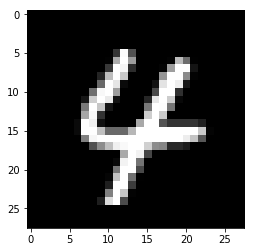

In [133]:
from matplotlib import pyplot as plt
origFig = plt.imshow(randImg, 'gray')

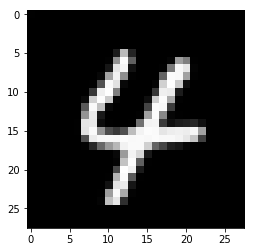

In [134]:
resFig = plt.imshow(resultImg, 'gray')

# Generate Autoencoder (Stage 2)

In [135]:
# Use encoder1 to generate the training and test-data for stage 2

x2_train = encoder1.predict(np.reshape(x1_train,(len(x1_train),28,28,1)))
x2_test = encoder1.predict(np.reshape(x1_test,(len(x1_test),28,28,1)))

print(x2_train.shape)
print(x2_test.shape)

(60000, 14, 14, 8)
(10000, 14, 14, 8)


In [136]:
print(codeShape1)

(14, 14, 8)


In [137]:
encoder2 = Sequential()
encoder2.add(Conv2D(8, (3,3), activation='relu', padding='same', input_shape=codeShape1)) 
encoder2.add(SpatialDropout2D(0.25))
encoder2.add(Conv2D(16, (3,3), strides=(2,2), activation='relu', padding='same'))

codeShape2 = (7,7,16)

decoder2 = Sequential()
decoder2.add(Conv2DTranspose(8, (3,3), strides=(2,2), activation='relu', padding='same', input_shape=codeShape2))

print(encoder2.summary())
print(decoder2.summary())

inputImage2 = Input(shape=codeShape1)
x = encoder2(inputImage2)
x = decoder2(x)
autoencoder2 = Model(inputImage2, x)
autoencoder2.compile(optimizer='adam', loss='binary_crossentropy')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_71 (Conv2D)           (None, 14, 14, 8)         584       
_________________________________________________________________
spatial_dropout2d_28 (Spatia (None, 14, 14, 8)         0         
_________________________________________________________________
conv2d_72 (Conv2D)           (None, 7, 7, 16)          1168      
Total params: 1,752
Trainable params: 1,752
Non-trainable params: 0
_________________________________________________________________
None
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_transpose_71 (Conv2DT (None, 14, 14, 8)         1160      
Total params: 1,160
Trainable params: 1,160
Non-trainable params: 0
_________________________________________________________________
None


In [138]:
# training network

history = autoencoder2.fit(x2_train, x2_train, epochs=4, batch_size=128, shuffle=True, validation_data=(x2_test,x2_test))

# 0.0661

Train on 60000 samples, validate on 10000 samples
Epoch 1/4
60000/60000 [==============================] - 124s 2ms/step - loss: -0.1070 - val_loss: -1.2637
Epoch 2/4
60000/60000 [==============================] - 116s 2ms/step - loss: -1.1880 - val_loss: -1.3687
Epoch 3/4
60000/60000 [==============================] - 124s 2ms/step - loss: -1.3101 - val_loss: -1.4402
Epoch 4/4
60000/60000 [==============================] - 132s 2ms/step - loss: -1.3945 - val_loss: -1.4594


In [147]:
# stitch together encoders and decoders to prove valid training

x = random.randint(0,testLength-1)
randImg = np.reshape(x_test[x], (1, 28, 28, 1)) 

resultImg = decoder1.predict(decoder2.predict(encoder2.predict(encoder1.predict(randImg))))
#resultImg = decoder1.predict(encoder1.predict(randImg))
#resultImg = autoencoder1.predict(randImg)

In [148]:
randImg = randImg.reshape(28,28)
resultImg = resultImg.reshape(28,28)

print(randImg.shape)
print(resultImg.shape)

(28, 28)
(28, 28)


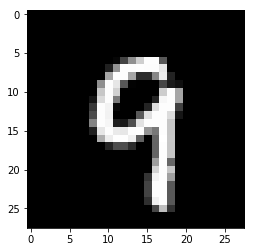

In [149]:
origFig = plt.imshow(randImg, 'gray')

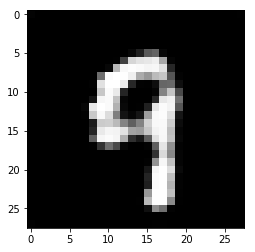

In [150]:
resFig = plt.imshow(resultImg, 'gray')

# tune auto-encoder 2

In [163]:
inputImageFull = Input(shape=inputShape)
x = encoder1(inputImageFull)
x = encoder2(x)
x = decoder2(x)
x = decoder1(x)
autoencoderfull = Model(inputImageFull, x)
autoencoderfull.compile(optimizer='adam', loss='binary_crossentropy')

In [164]:
# training network

history = autoencoderfull.fit(x1_train, x1_train, epochs=4, batch_size=128, shuffle=True, validation_data=(x1_test,x1_test))

# 0.0661

Train on 60000 samples, validate on 10000 samples
Epoch 1/4
60000/60000 [==============================] - 300s 5ms/step - loss: 0.0822 - val_loss: 0.0689
Epoch 2/4
60000/60000 [==============================] - 278s 5ms/step - loss: 0.0724 - val_loss: 0.0689
Epoch 3/4
60000/60000 [==============================] - 262s 4ms/step - loss: 0.0702 - val_loss: 0.0678
Epoch 4/4
60000/60000 [==============================] - 241s 4ms/step - loss: 0.0691 - val_loss: 0.0677


In [177]:
# stitch together encoders and decoders to prove valid training

x = random.randint(0,testLength-1)
randImg = np.reshape(x_test[x], (1, 28, 28, 1)) 

resultImg = autoencoderfull.predict(randImg)

In [178]:
randImg = randImg.reshape(28,28)
resultImg = resultImg.reshape(28,28)

print(randImg.shape)
print(resultImg.shape)

(28, 28)
(28, 28)


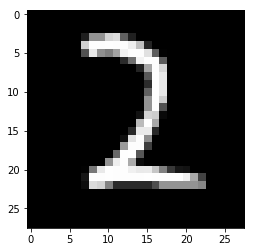

In [179]:
origFig = plt.imshow(randImg, 'gray')

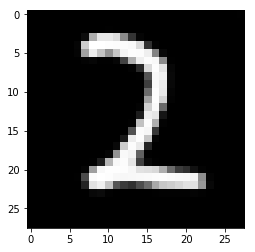

In [180]:
resFig = plt.imshow(resultImg, 'gray')